<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">

# **Procesamiento de lenguaje natural - Desafio 3**
---
# *"Modelo de lenguaje con tokenizaci√≥n por caracteres"*
---
##**Laboratorio de Sistemas Embebidos**                                  
##**David Canal**

---
##**Consigna de trabajo**

- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validaci√≥n.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determ√≠stico y estoc√°stico. En este √∫ltimo caso observar el efecto de la temperatura en la generaci√≥n de secuencias.

##**Sugerencias**
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validaci√≥n para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


##**Resoluci√≥n**
---
## **1. Selecci√≥n del Dataset**

### An√°lisis de la elecci√≥n del corpus

Para este desafio, se seleccion√≥ "El Quijote" de Miguel de Cervantes como corpus principal. Esta elecci√≥n se sustenta en los siguientes puntos:

1. Riqueza ling√º√≠stica: texto cl√°sico en espa√±ol con vocabulario extenso y estructuras gramaticales complejas.
2. Tama√±o apropiado: suficientemente grande para entrenar un modelo robusto pero manejable
3. Diversidad textual: mezcla de narraci√≥n, di√°logos y descripciones.
4. Desaf√≠o t√©cnico: texto del siglo XVII con expresiones arcaicas que pondr√° a prueba la capacidad del modelo.

A modo de comparaci√≥n, tambi√©n se utilizaron fragmentos de "Cien a√±os de soledad" de Gabriel Garc√≠a M√°rquez. Esto permitir√° evaluar el comportamiento del modelo frente a diferentes estilos literarios.


In [74]:
%pip install pandas matplotlib scikit-learn bs4 tensorflow

Note: you may need to restart the kernel to use updated packages.


In [75]:
# Importaci√≥n de librer√≠as necesarias
import random
import io
import pickle
import urllib.request
import re
import time

import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [76]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [77]:
# Descarga y procesamiento del dataset - El Quijote

try:
    # Descargar desde el Proyecto Gutenberg (versi√≥n en espa√±ol)
    url_quijote = "https://www.gutenberg.org/files/2000/2000-0.txt"
    response = urllib.request.urlopen(url_quijote)
    raw_text = response.read().decode('utf-8')

    # Limpiar el texto - remover headers y footers del Gutenberg
    lines = raw_text.split('\n')
    start_idx = 0
    end_idx = len(lines)

    # Encontrar el inicio del texto real
    for i, line in enumerate(lines):
        if 'PRIMERA PARTE' in line or 'Cap√≠tulo' in line:
            start_idx = i
            break

    # Encontrar el final del texto
    for i in range(len(lines)-1, -1, -1):
        if 'End of Project Gutenberg' in lines[i] or 'FIN' in lines[i]:
            end_idx = i
            break

    # Extraer solo el texto del libro
    quijote_lines = lines[start_idx:end_idx]
    quijote_text = '\n'.join(quijote_lines)

    print(f"Texto descargado exitosamente")
    print(f"Longitud del texto: {len(quijote_text):,} caracteres")
    print(f"Primeras 500 caracteres:")
    print("-" * 50)
    print(quijote_text[:500])
    print("-" * 50)

except Exception as e:
    print(f"Error descargando El Quijote: {e}")
    print("Usando texto de respaldo...")

    # Texto de respaldo si falla la descarga
    quijote_text = """
    En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que viv√≠a un hidalgo de los de lanza en astillero, adarga antigua, roc√≠n flaco y galgo corredor. Una olla de algo m√°s vaca que carnero, salpic√≥n las m√°s noches, duelos y quebrantos los s√°bados, lentejas los viernes, alg√∫n palomino de a√±adidura los domingos, consum√≠an las tres partes de su hacienda. El resto della conclu√≠an sayo de velarte, calzas de velludo para las fiestas, con sus pantuflos de lo mesmo, y los d√≠as de entresemana se honraba con su vellor√≠ de lo m√°s fino.
    """


Texto descargado exitosamente
Longitud del texto: 2,127,523 caracteres
Primeras 500 caracteres:
--------------------------------------------------
Cap√≠tulo primero. Que trata de la condici√≥n y ejercicio del famoso hidalgo
don Quijote de la Mancha

En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que viv√≠a un hidalgo de los de lanza en astillero, adarga antigua,
roc√≠n flaco y galgo corredor. Una olla de algo m√°s vaca que carnero,
salpic√≥n las m√°s noches, duelos y quebrantos los s√°bados, lantejas los
viernes, alg√∫n palomino de a√±adidura los domingos, consum√≠an las tres
partes de su hacienda. El resto d
--------------------------------------------------


In [78]:
# Preprocesamiento del texto
print("Preprocesando el texto...")

# Convertir a min√∫sculas y limpiar
quijote_text = quijote_text.lower()

# Remover caracteres especiales pero mantener puntuaci√≥n b√°sica
# Mantenemos: letras, n√∫meros, espacios, puntuaci√≥n b√°sica
quijote_text = re.sub(r'[^\w\s.,!?;:()"-]', '', quijote_text)

# Normalizar espacios m√∫ltiples
quijote_text = re.sub(r'\s+', ' ', quijote_text)

# Limitar el tama√±o del texto para entrenamiento eficiente
max_text_length = 100000  # 100k caracteres
if len(quijote_text) > max_text_length:
    quijote_text = quijote_text[:max_text_length]
    print(f"Texto truncado a {max_text_length:,} caracteres para eficiencia")

print(f"Texto final: {len(quijote_text):,} caracteres")
print(f"Muestra del texto procesado:")
print("-" * 50)
print(quijote_text[:300])
print("-" * 50)


Preprocesando el texto...
Texto truncado a 100,000 caracteres para eficiencia
Texto final: 100,000 caracteres
Muestra del texto procesado:
--------------------------------------------------
cap√≠tulo primero. que trata de la condici√≥n y ejercicio del famoso hidalgo don quijote de la mancha en un lugar de la mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que viv√≠a un hidalgo de los de lanza en astillero, adarga antigua, roc√≠n flaco y galgo corredor. una olla de algo m√°s v
--------------------------------------------------


---
## **2. Tokenizaci√≥n por Caracteres**

En este trabajo se opt√≥ por la tokenizaci√≥n por caracteres, ya que ofrece varias ventajas pr√°cticas para el tipo de an√°lisis realizado. Este enfoque utiliza un vocabulario mucho m√°s peque√±o (alrededor de 100 caracteres √∫nicos), lo que evita los problemas de palabras desconocidas y permite procesar cualquier texto sin limitaciones. Adem√°s, brinda flexibilidad al modelo, ya que puede generar palabras nuevas no vistas durante el entrenamiento, y resulta m√°s sencillo de implementar al no requerir diccionarios complejos.

Si bien este m√©todo implica manejar secuencias m√°s largas y un mayor costo computacional, se consider√≥ que sus beneficios (particularmente la capacidad de generalizar y adaptarse a distintos estilos literarios) lo hacen adecuado para el objetivo del trabajo.


In [79]:
# An√°lisis del vocabulario de caracteres
print("Analizando vocabulario de caracteres")

# Obtener vocabulario √∫nico de caracteres
chars_vocab = set(quijote_text)
vocab_size = len(chars_vocab)

print(f"Tama√±o del vocabulario: {vocab_size} caracteres √∫nicos")
print(f"Caracteres encontrados: {sorted(chars_vocab)}")

# Crear diccionarios de mapeo
char2idx = {char: idx for idx, char in enumerate(sorted(chars_vocab))}
idx2char = {idx: char for char, idx in char2idx.items()}

print(f"Diccionarios creados:")
print(f"   - char2idx: {len(char2idx)} mapeos")
print(f"   - idx2char: {len(idx2char)} mapeos")

# An√°lisis de frecuencia de caracteres
char_freq = {}
for char in quijote_text:
    char_freq[char] = char_freq.get(char, 0) + 1

# Mostrar los 20 caracteres m√°s frecuentes
sorted_chars = sorted(char_freq.items(), key=lambda x: x[1], reverse=True)
print(f"\n Top 20 caracteres m√°s frecuentes:")
for i, (char, freq) in enumerate(sorted_chars[:20]):
    print(f"   {i+1:2d}. '{char}' -> {freq:6,} veces ({freq/len(quijote_text)*100:.2f}%)")


Analizando vocabulario de caracteres
Tama√±o del vocabulario: 42 caracteres √∫nicos
Caracteres encontrados: [' ', '!', '"', '(', ')', ',', '-', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z', '√°', '√©', '√≠', '√±', '√≥', '√∫', '√º']
Diccionarios creados:
   - char2idx: 42 mapeos
   - idx2char: 42 mapeos

 Top 20 caracteres m√°s frecuentes:
    1. ' ' -> 18,246 veces (18.25%)
    2. 'e' -> 10,541 veces (10.54%)
    3. 'a' ->  9,749 veces (9.75%)
    4. 'o' ->  7,352 veces (7.35%)
    5. 's' ->  5,793 veces (5.79%)
    6. 'n' ->  5,038 veces (5.04%)
    7. 'r' ->  4,866 veces (4.87%)
    8. 'l' ->  4,798 veces (4.80%)
    9. 'd' ->  4,211 veces (4.21%)
   10. 'u' ->  3,791 veces (3.79%)
   11. 'i' ->  3,402 veces (3.40%)
   12. 'c' ->  2,853 veces (2.85%)
   13. 't' ->  2,826 veces (2.83%)
   14. 'm' ->  2,051 veces (2.05%)
   15. ',' ->  1,904 veces (1.90%)
   16. 'p' ->  1,682 veces (1.68%)
   

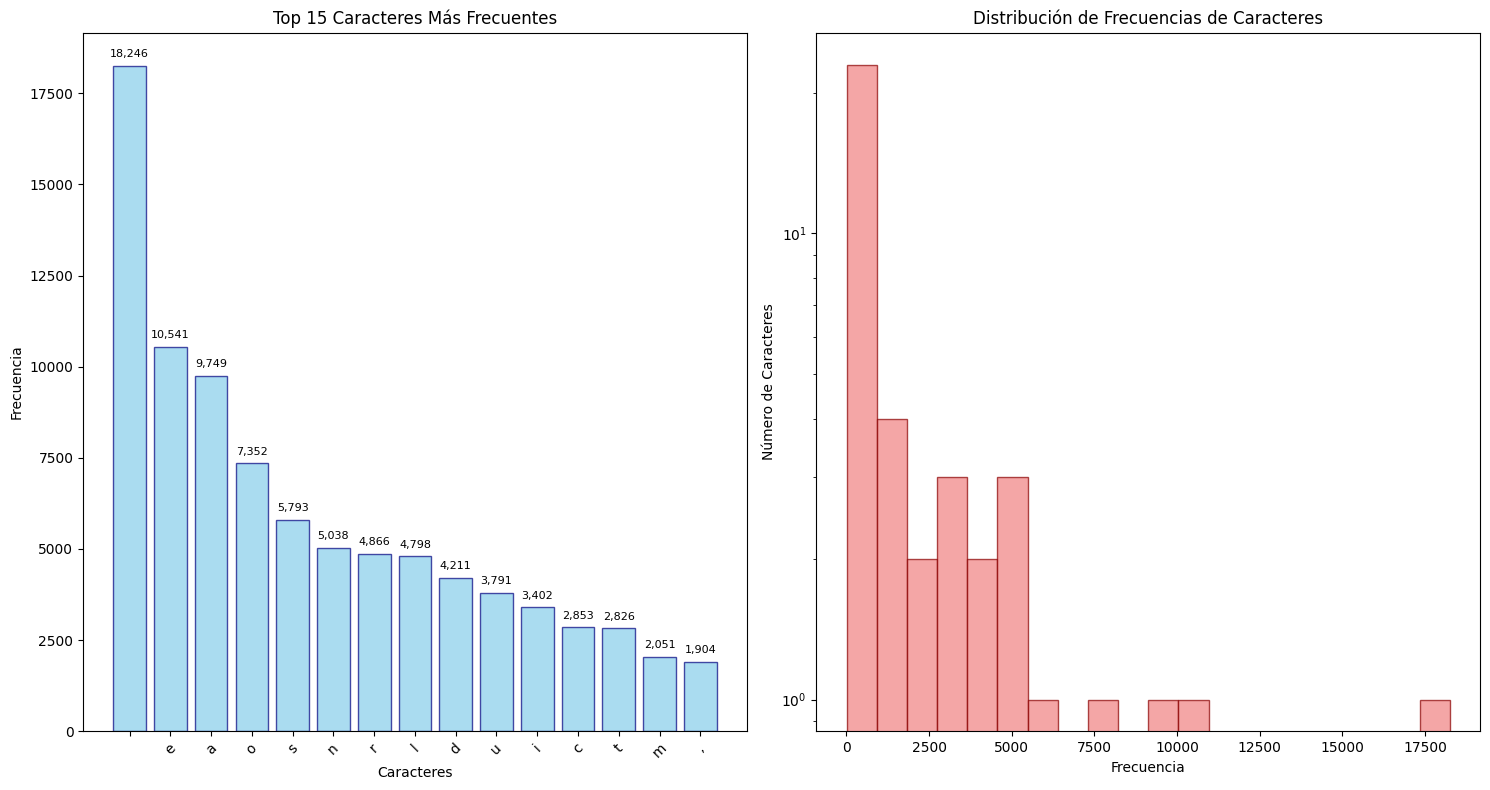

Estad√≠sticas del vocabulario:
   - Caracteres √∫nicos: 42
   - Caracter m√°s frecuente: ' ' (18,246 veces)
   - Caracter menos frecuente: ')' (3 veces)
   - Entrop√≠a del texto: 4.19 bits


In [80]:
# Visualizaci√≥n de la distribuci√≥n de caracteres
plt.figure(figsize=(15, 8))

# Gr√°fico de barras de los caracteres m√°s frecuentes
top_chars = sorted_chars[:15]
chars, freqs = zip(*top_chars)

plt.subplot(1, 2, 1)
bars = plt.bar(range(len(chars)), freqs, color='skyblue', edgecolor='navy', alpha=0.7)
plt.xlabel('Caracteres')
plt.ylabel('Frecuencia')
plt.title('Top 15 Caracteres M√°s Frecuentes')
plt.xticks(range(len(chars)), chars, rotation=45)

# Agregar valores en las barras
for bar, freq in zip(bars, freqs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(freqs)*0.01,
             f'{freq:,}', ha='center', va='bottom', fontsize=8)

# Gr√°fico de distribuci√≥n general
plt.subplot(1, 2, 2)
all_freqs = [freq for char, freq in sorted_chars]
plt.hist(all_freqs, bins=20, color='lightcoral', edgecolor='darkred', alpha=0.7)
plt.xlabel('Frecuencia')
plt.ylabel('N√∫mero de Caracteres')
plt.title('Distribuci√≥n de Frecuencias de Caracteres')
plt.yscale('log')

plt.tight_layout()
plt.show()

print(f"Estad√≠sticas del vocabulario:")
print(f"   - Caracteres √∫nicos: {vocab_size}")
print(f"   - Caracter m√°s frecuente: '{sorted_chars[0][0]}' ({sorted_chars[0][1]:,} veces)")
print(f"   - Caracter menos frecuente: '{sorted_chars[-1][0]}' ({sorted_chars[-1][1]:,} veces)")
print(f"   - Entrop√≠a del texto: {sum(-freq/len(quijote_text) * np.log2(freq/len(quijote_text)) for char, freq in char_freq.items()):.2f} bits")


---
## **3. Elecci√≥n del tama√±o de contexto**
 Para la elecci√≥n del tama√±o del contexto se consideraron los siguiente puntos:
* Memoria computacional: contextos largos requieren m√°s memoria.
* Dependencias temporales: texto necesita contexto suficiente para coherencia.
* Tiempo de entrenamiento: secuencias largas aumentan el tiempo de entrenamiento.
* Calidad de generaci√≥n: contexto muy corto puede generar texto incoherente.

Para abordar estos puntos, se procedi√≥ a analizar la distribuci√≥n de longitudes de las oraciones presentes en el corpus, con el objetivo de identificar un rango representativo. A partir de este an√°lisis, se eligi√≥ un percentil que permitiera capturar la mayor√≠a de los patrones ling√º√≠sticos relevantes, manteniendo un equilibrio adecuado entre la coherencia del texto y la eficiencia computacional del modelo.

Analizando longitudes de secuencias
Estad√≠sticas de longitudes de oraciones:
   - N√∫mero de oraciones: 453
   - Longitud promedio: 218.7 caracteres
   - Longitud mediana: 175.0 caracteres
   - Longitud m√≠nima: 11 caracteres
   - Longitud m√°xima: 1456 caracteres
   - Desviaci√≥n est√°ndar: 183.1 caracteres

 Percentiles de longitud:
   - P50: 175.0 caracteres
   - P75: 285.0 caracteres
   - P90: 437.6 caracteres
   - P95: 542.2 caracteres
   - P99: 803.7 caracteres


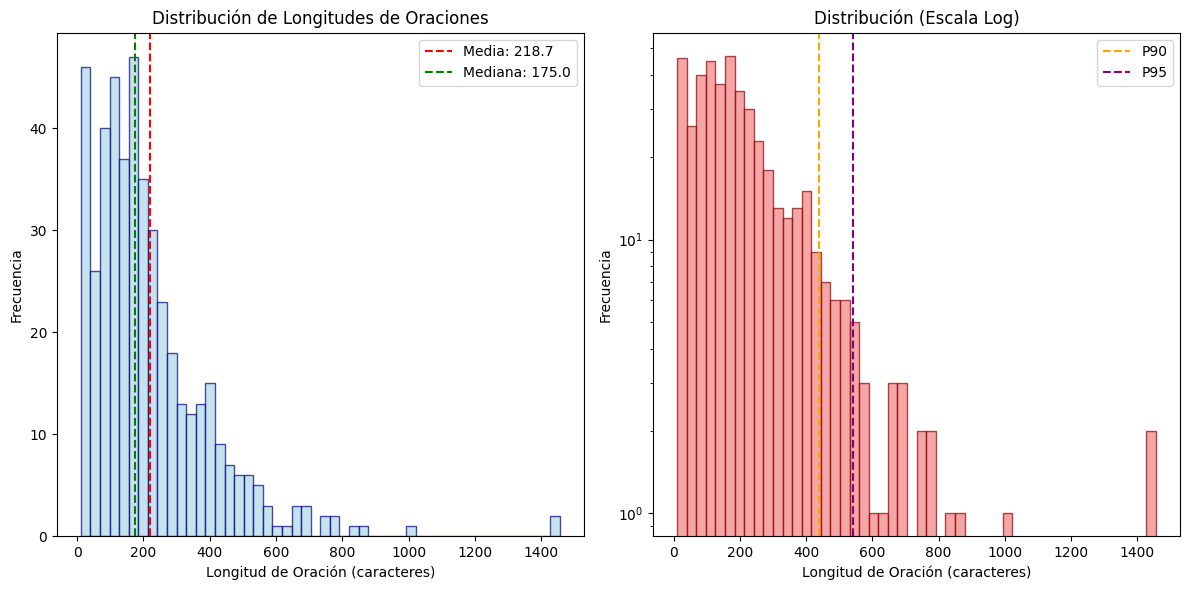

In [81]:
# An√°lisis de longitudes de secuencias para determinar el tama√±o de contexto
print("Analizando longitudes de secuencias")

# Dividir el texto en oraciones para analizar longitudes
sentences = re.split(r'[.!?]+', quijote_text)
sentences = [s.strip() for s in sentences if len(s.strip()) > 10]  # Filtrar oraciones muy cortas

# Calcular longitudes de caracteres por oraci√≥n
sentence_lengths = [len(sentence) for sentence in sentences]

print(f"Estad√≠sticas de longitudes de oraciones:")
print(f"   - N√∫mero de oraciones: {len(sentences):,}")
print(f"   - Longitud promedio: {np.mean(sentence_lengths):.1f} caracteres")
print(f"   - Longitud mediana: {np.median(sentence_lengths):.1f} caracteres")
print(f"   - Longitud m√≠nima: {np.min(sentence_lengths)} caracteres")
print(f"   - Longitud m√°xima: {np.max(sentence_lengths)} caracteres")
print(f"   - Desviaci√≥n est√°ndar: {np.std(sentence_lengths):.1f} caracteres")

# An√°lisis de percentiles
percentiles = [50, 75, 90, 95, 99]
print(f"\n Percentiles de longitud:")
for p in percentiles:
    val = np.percentile(sentence_lengths, p)
    print(f"   - P{p}: {val:.1f} caracteres")

# Visualizaci√≥n de la distribuci√≥n
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(sentence_lengths, bins=50, color='lightblue', edgecolor='navy', alpha=0.7)
plt.axvline(np.mean(sentence_lengths), color='red', linestyle='--', label=f'Media: {np.mean(sentence_lengths):.1f}')
plt.axvline(np.median(sentence_lengths), color='green', linestyle='--', label=f'Mediana: {np.median(sentence_lengths):.1f}')
plt.xlabel('Longitud de Oraci√≥n (caracteres)')
plt.ylabel('Frecuencia')
plt.title('Distribuci√≥n de Longitudes de Oraciones')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(sentence_lengths, bins=50, color='lightcoral', edgecolor='darkred', alpha=0.7)
plt.axvline(np.percentile(sentence_lengths, 90), color='orange', linestyle='--', label='P90')
plt.axvline(np.percentile(sentence_lengths, 95), color='purple', linestyle='--', label='P95')
plt.xlabel('Longitud de Oraci√≥n (caracteres)')
plt.ylabel('Frecuencia')
plt.title('Distribuci√≥n (Escala Log)')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()


In [82]:
# Selecci√≥n del tama√±o de contexto basado en el an√°lisis
print("Seleccionando tama√±o de contexto")

# Usar el percentil 90 para capturar la mayor√≠a de patrones sin ser excesivo
max_context_size = int(np.percentile(sentence_lengths, 90))
print(f"Tama√±o de contexto seleccionado: {max_context_size} caracteres")
print(f"   - Esto captura el {90}% de las oraciones")
print(f"   - Balance entre coherencia y eficiencia computacional")

# Verificar que el tama√±o sea razonable
if max_context_size > 200:
    max_context_size = 100  # Limitar para eficiencia
    print(f"Contexto limitado a {max_context_size} caracteres para eficiencia")
elif max_context_size < 50:
    max_context_size = 50   # M√≠nimo para coherencia
    print(f"Contexto aumentado a {max_context_size} caracteres para coherencia")

print(f"Tama√±o final de contexto: {max_context_size} caracteres")


Seleccionando tama√±o de contexto
Tama√±o de contexto seleccionado: 437 caracteres
   - Esto captura el 90% de las oraciones
   - Balance entre coherencia y eficiencia computacional
Contexto limitado a 100 caracteres para eficiencia
Tama√±o final de contexto: 100 caracteres


---
## **4. Estructuraci√≥n del Dataset** (Many-to-Many)

Se adopt√≥ una estructura Many-to-Many, dado que permite que el modelo aprenda relaciones entre todos los elementos de la secuencia. Este enfoque favorece un aprendizaje m√°s denso, dado que cada posici√≥n de la secuencia contribuye al c√°lculo del gradiente, mejorando as√≠ la propagaci√≥n del aprendizaje a lo largo de toda la cadena. Adem√°s, facilita que la red capture dependencias temporales y mantenga la coherencia del texto generado, aprovechando de forma m√°s eficiente la capacidad de las RNN.

En esta configuraci√≥n, la entrada est√° compuesta por una secuencia de caracteres [x‚ÇÄ, x‚ÇÅ, ..., x‚Çô], mientras que el target corresponde a la misma secuencia desplazada una posici√≥n [x‚ÇÅ, x‚ÇÇ, ..., x‚Çô‚Çä‚ÇÅ]. De este modo, el objetivo del modelo es predecir el siguiente car√°cter en cada paso, aprendiendo progresivamente las transiciones entre los caracteres y la estructura del texto.

In [83]:
# Tokenizaci√≥n del texto completo
print("Tokenizando texto completo")

# Convertir texto a secuencia de √≠ndices
tokenized_text = [char2idx[char] for char in quijote_text]

print(f"Texto tokenizado: {len(tokenized_text):,} tokens")
print(f"Muestra de tokens: {tokenized_text[:50]}")
print(f"Texto original: '{quijote_text[:50]}'")
print(f"Tokens correspondientes: {[idx2char[idx] for idx in tokenized_text[:50]]}")

# Verificar que la tokenizaci√≥n es reversible
reconstructed = ''.join([idx2char[idx] for idx in tokenized_text[:100]])
print(f"Verificaci√≥n reversibilidad: {quijote_text[:100] == reconstructed}")


Tokenizando texto completo
Texto tokenizado: 100,000 tokens
Muestra de tokens: [13, 11, 25, 37, 29, 30, 21, 24, 0, 25, 27, 19, 22, 15, 27, 24, 7, 0, 26, 30, 15, 0, 29, 27, 11, 29, 11, 0, 14, 15, 0, 21, 11, 0, 13, 24, 23, 14, 19, 13, 19, 39, 23, 0, 33, 0, 15, 20, 15, 27]
Texto original: 'cap√≠tulo primero. que trata de la condici√≥n y ejer'
Tokens correspondientes: ['c', 'a', 'p', '√≠', 't', 'u', 'l', 'o', ' ', 'p', 'r', 'i', 'm', 'e', 'r', 'o', '.', ' ', 'q', 'u', 'e', ' ', 't', 'r', 'a', 't', 'a', ' ', 'd', 'e', ' ', 'l', 'a', ' ', 'c', 'o', 'n', 'd', 'i', 'c', 'i', '√≥', 'n', ' ', 'y', ' ', 'e', 'j', 'e', 'r']
Verificaci√≥n reversibilidad: True


In [84]:
# Creaci√≥n de secuencias de entrenamiento y validaci√≥n
print("Creando secuencias de entrenamiento y validaci√≥n...")

# Par√°metros de divisi√≥n
p_val = 0.1  # 10% para validaci√≥n
num_val = int(np.ceil(len(tokenized_text) * p_val / max_context_size))

print(f"Par√°metros de divisi√≥n:")
print(f"   - Texto total: {len(tokenized_text):,} tokens")
print(f"   - Tama√±o de contexto: {max_context_size} tokens")
print(f"   - Porcentaje validaci√≥n: {p_val*100}%")
print(f"   - Secuencias de validaci√≥n: {num_val}")

# Separar texto de entrenamiento y validaci√≥n
train_text = tokenized_text[:-num_val * max_context_size]
val_text = tokenized_text[-num_val * max_context_size:]

print(f"Divisi√≥n completada:")
print(f"   - Texto entrenamiento: {len(train_text):,} tokens")
print(f"   - Texto validaci√≥n: {len(val_text):,} tokens")

# Crear secuencias de validaci√≥n
tokenized_sentences_val = []
for i in range(num_val):
    start_idx = i * max_context_size
    end_idx = start_idx + max_context_size
    if end_idx <= len(val_text):
        tokenized_sentences_val.append(val_text[start_idx:end_idx])

print(f"Secuencias de validaci√≥n creadas: {len(tokenized_sentences_val)}")


Creando secuencias de entrenamiento y validaci√≥n...
Par√°metros de divisi√≥n:
   - Texto total: 100,000 tokens
   - Tama√±o de contexto: 100 tokens
   - Porcentaje validaci√≥n: 10.0%
   - Secuencias de validaci√≥n: 100
Divisi√≥n completada:
   - Texto entrenamiento: 90,000 tokens
   - Texto validaci√≥n: 10,000 tokens
Secuencias de validaci√≥n creadas: 100


In [85]:
# Crear secuencias de entrenamiento con estructura many-to-many
print("Creando secuencias de entrenamiento (many-to-many)")

# Generar todas las secuencias de entrenamiento
tokenized_sentences_train = []
for i in range(len(train_text) - max_context_size + 1):
    sequence = train_text[i:i + max_context_size]
    tokenized_sentences_train.append(sequence)

print(f"Secuencias de entrenamiento creadas: {len(tokenized_sentences_train):,}")

# Crear estructura many-to-many
# X: secuencias de entrada [x0, x1, ..., xN]
# y: secuencias de salida [x1, x2, ..., xN+1]
X = np.array(tokenized_sentences_train[:-1])  # Todas excepto la √∫ltima
y = np.array(tokenized_sentences_train[1:])   # Todas excepto la primera

print(f"Estructura many-to-many creada:")
print(f"   - X shape: {X.shape}")
print(f"   - y shape: {y.shape}")
print(f"   - Ejemplo X[0]: {X[0][:20]}...")
print(f"   - Ejemplo y[0]: {y[0][:20]}...")

# Verificar que la estructura es correcta
print(f"Verificaci√≥n de estructura:")
print(f"   - X[0] representa: '{''.join([idx2char[idx] for idx in X[0][:30]])}...'")
print(f"   - y[0] representa: '{''.join([idx2char[idx] for idx in y[0][:30]])}...'")
print(f"   - Diferencia: y[0] es X[0] desplazado 1 posici√≥n hacia la izquierda")


Creando secuencias de entrenamiento (many-to-many)
Secuencias de entrenamiento creadas: 89,901
Estructura many-to-many creada:
   - X shape: (89900, 100)
   - y shape: (89900, 100)
   - Ejemplo X[0]: [13 11 25 37 29 30 21 24  0 25 27 19 22 15 27 24  7  0 26 30]...
   - Ejemplo y[0]: [11 25 37 29 30 21 24  0 25 27 19 22 15 27 24  7  0 26 30 15]...
Verificaci√≥n de estructura:
   - X[0] representa: 'cap√≠tulo primero. que trata de...'
   - y[0] representa: 'ap√≠tulo primero. que trata de ...'
   - Diferencia: y[0] es X[0] desplazado 1 posici√≥n hacia la izquierda


## **5. Arquitecturas de Redes Neuronales Recurrentes**

En esta etapa se analizaron distintas arquitecturas de Redes Neuronales Recurrentes (RNN) con el fin de seleccionar la m√°s adecuada para el problema planteado. En primer lugar, se consider√≥ la SimpleRNN (Elman Network), una arquitectura b√°sica caracterizada por su simplicidad y r√°pido entrenamiento, ya que cuenta con pocos par√°metros. Sin embargo, presenta limitaciones importantes, como el problema del vanishing gradient y la dificultad para capturar dependencias largas, lo que la hace m√°s adecuada para textos simples o secuencias cortas.

Posteriormente, se evalu√≥ la LSTM (Long Short-Term Memory), que introduce una estructura de compuertas capaz de mantener informaci√≥n a largo plazo, resolviendo en gran medida el problema del vanishing gradient. Esta caracter√≠stica la vuelve ideal para textos complejos y secuencias largas, aunque su principal desventaja es el mayor costo computacional debido al n√∫mero de par√°metros y al tiempo de entrenamiento.

Finalmente, se analiz√≥ la GRU (Gated Recurrent Unit), una variante simplificada de la LSTM que busca un equilibrio entre rendimiento y eficiencia. Requiere menos par√°metros y entrena m√°s r√°pido, aunque puede resultar ligeramente menos potente en tareas que exigen un modelado profundo de dependencias temporales. Por este motivo, la GRU suele representar un compromiso efectivo entre complejidad y capacidad de generalizaci√≥n.

In [86]:
# Funci√≥n para crear diferentes arquitecturas RNN
def create_rnn_model(architecture='lstm', vocab_size=vocab_size, context_size=max_context_size,
                    hidden_size=128, dropout_rate=0.2, return_sequences=True):
    """
    Crea un modelo RNN con la arquitectura especificada

    Args:
        architecture: 'simple', 'lstm', o 'gru'
        vocab_size: tama√±o del vocabulario
        context_size: tama√±o del contexto
        hidden_size: tama√±o de la capa oculta
        dropout_rate: tasa de dropout
        return_sequences: si retornar secuencias completas

    Returns:
        modelo compilado de Keras
    """

    from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Embedding, Dropout, TimeDistributed, CategoryEncoding
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.losses import SparseCategoricalCrossentropy

    model = Sequential()

    # Capa de entrada: One-hot encoding de caracteres
    model.add(TimeDistributed(
        CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"),
        input_shape=(None, 1)
    ))

    # Capa RNN seg√∫n la arquitectura seleccionada
    if architecture == 'simple':
        model.add(SimpleRNN(
            hidden_size,
            return_sequences=return_sequences,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        ))
    elif architecture == 'lstm':
        model.add(LSTM(
            hidden_size,
            return_sequences=return_sequences,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        ))
    elif architecture == 'gru':
        model.add(GRU(
            hidden_size,
            return_sequences=return_sequences,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        ))
    else:
        raise ValueError(f"Arquitectura no soportada: {architecture}")

    # Capa de salida: predicci√≥n del siguiente car√°cter
    model.add(Dense(vocab_size, activation='softmax'))

    # Compilar modelo
    model.compile(
        loss=SparseCategoricalCrossentropy(),
        optimizer='rmsprop',
        metrics=['accuracy']
    )

    return model

In [87]:
# Crear y comparar los tres tipos de modelos RNN
print("Creando modelos RNN para comparaci√≥n")

# Par√°metros de los modelos
hidden_size = 128
dropout_rate = 0.2

# Crear los tres modelos
models = {}
architectures = ['simple', 'lstm', 'gru']

for arch in architectures:
    print(f"Creando modelo {arch.upper()}...")
    models[arch] = create_rnn_model(
        architecture=arch,
        vocab_size=vocab_size,
        context_size=max_context_size,
        hidden_size=hidden_size,
        dropout_rate=dropout_rate
    )

    print(f"Modelo {arch.upper()} creado")
    print(f"   - Par√°metros totales: {models[arch].count_params():,}")
    print(f"   - Arquitectura: {arch.upper()}")

print(f"\nResumen de modelos creados:")
for arch, model in models.items():
    print(f"   - {arch.upper()}: {model.count_params():,} par√°metros")

# Mostrar arquitectura detallada del modelo LSTM como ejemplo
print(f"\n Arquitectura detallada del modelo LSTM:")
models['lstm'].summary()


Creando modelos RNN para comparaci√≥n
Creando modelo SIMPLE...
Modelo SIMPLE creado
   - Par√°metros totales: 27,306
   - Arquitectura: SIMPLE
Creando modelo LSTM...
Modelo LSTM creado
   - Par√°metros totales: 92,970
   - Arquitectura: LSTM
Creando modelo GRU...
Modelo GRU creado
   - Par√°metros totales: 71,466
   - Arquitectura: GRU

Resumen de modelos creados:
   - SIMPLE: 27,306 par√°metros
   - LSTM: 92,970 par√°metros
   - GRU: 71,466 par√°metros

 Arquitectura detallada del modelo LSTM:


/Users/dcanal1820/miniforge/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ time_distributed_7              ‚îÇ (None, None, 42)       ‚îÇ             0 ‚îÇ
‚îÇ (TimeDistributed)               ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_2 (LSTM)                   ‚îÇ (None, None, 128)      ‚îÇ        87,552 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_7 (Dense)                 ‚îÇ (None, None, 42)       ‚îÇ         5,418 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 92,970 (363.16 KB)

 Trainable params: 92,970 (363.16 KB)

 Non-trainable params: 0 (0.00 B)

---
## **6. Callback personalizado para perplejidad**

### An√°lisis de la m√©trica de Perplejidad

Para el control del entrenamiento se implement√≥ un callback personalizado basado en la m√©trica de perplejidad, una medida especialmente √∫til en modelos de lenguaje. La perplejidad se define como exp(-log_likelihood) y permite interpretar cu√°ntas opciones, en promedio, el modelo considera posibles en cada paso de predicci√≥n. Un valor de 1 indica una predicci√≥n perfecta, mientras que una perplejidad similar al tama√±o del vocabulario refleja un comportamiento aleatorio. Por tanto, valores menores al tama√±o del vocabulario implican que el modelo est√° aprendiendo patrones significativos.

Este enfoque se utiliz√≥ tambi√©n como criterio de early stopping, deteniendo el entrenamiento cuando la perplejidad dejaba de mejorar. Esto permit√≠o prevenir el sobreajuste, reducir el tiempo de entrenamiento y garantizar la selecci√≥n del mejor modelo para la tarea de generaci√≥n de texto.

In [88]:
# Callback personalizado para calcular perplejidad y early stopping
class PerplexityCallback(keras.callbacks.Callback):
    """
    Callback personalizado para calcular perplejidad en cada epoch
    e implementar early stopping basado en la mejora de perplejidad
    """

    def __init__(self, val_data, history_ppl, patience=5, min_delta=0.01):
        super().__init__()
        self.val_data = val_data
        self.history_ppl = history_ppl
        self.patience = patience
        self.min_delta = min_delta
        self.min_perplexity = np.inf
        self.patience_counter = 0
        self.best_weights = None

        # Preprocesar datos de validaci√≥n para c√°lculo eficiente
        self._prepare_validation_data()

    def _prepare_validation_data(self):
        """Preprocesa los datos de validaci√≥n para c√°lculo eficiente de perplejidad"""
        self.val_targets = []
        self.val_inputs = []
        self.val_info = []

        count = 0
        for seq in self.val_data:
            if len(seq) > 1:
                # Crear subsecuencias para evaluaci√≥n
                for i in range(1, len(seq)):
                    input_seq = seq[:i]
                    target_char = seq[i]

                    # Padding si es necesario
                    if len(input_seq) < max_context_size:
                        input_seq = [0] * (max_context_size - len(input_seq)) + input_seq
                    else:
                        input_seq = input_seq[-max_context_size:]

                    self.val_inputs.append(input_seq)
                    self.val_targets.append(target_char)
                    self.val_info.append((count, count + 1))
                    count += 1

        self.val_inputs = np.array(self.val_inputs)
        self.val_targets = np.array(self.val_targets)

        print(f"Datos de validaci√≥n preparados: {len(self.val_inputs)} secuencias")

    def on_epoch_end(self, epoch, logs=None):
        """Calcula perplejidad al final de cada epoch"""

        # Obtener predicciones del modelo
        predictions = self.model.predict(self.val_inputs, verbose=0)

        # Calcular perplejidad para cada secuencia
        perplexities = []
        for i, (start, end) in enumerate(self.val_info):
            if start < len(predictions):
                target_idx = self.val_targets[i]
                prob = predictions[start, -1, target_idx]  # Probabilidad del car√°cter target
                perplexities.append(prob)

        # Calcular perplejidad promedio
        if perplexities:
            avg_perplexity = np.exp(-np.mean(np.log(np.array(perplexities) + 1e-10)))
        else:
            avg_perplexity = np.inf

        # Guardar en historial
        self.history_ppl.append(avg_perplexity)

        print(f"Epoch {epoch + 1} - Perplejidad: {avg_perplexity:.4f}")

        # Early stopping
        if avg_perplexity < self.min_perplexity - self.min_delta:
            self.min_perplexity = avg_perplexity
            self.patience_counter = 0
            self.best_weights = self.model.get_weights()
            print(f"Nueva mejor perplejidad: {avg_perplexity:.4f}")
        else:
            self.patience_counter += 1
            print(f"Sin mejora ({self.patience_counter}/{self.patience})")

            if self.patience_counter >= self.patience:
                print(f"Early stopping activado en epoch {epoch + 1}")
                self.model.stop_training = True
                if self.best_weights is not None:
                    self.model.set_weights(self.best_weights)
                    print(f"Pesos restaurados al mejor modelo")


---
## **7. Entrenamiento y Comparaci√≥n de Modelos**

El proceso de entrenamiento se realiz√≥ ajustando los principales par√°metros para optimizar el rendimiento del modelo sin comprometer la eficiencia computacional. Se entren√≥ durante 20 √©pocas, aplicando early stopping con una paciencia de 5 √©pocas para detener el proceso cuando la perplejidad de validaci√≥n dejara de mejorar. Se utiliz√≥ un batch size de 256, buscando un equilibrio entre el uso de memoria y la estabilidad del aprendizaje, y el optimizador RMSprop, recomendado para redes recurrentes por su buen desempe√±o en la adaptaci√≥n din√°mica de la tasa de aprendizaje.

Durante el entrenamiento se monitorizaron diversas m√©tricas de evaluaci√≥n. La perplejidad se emple√≥ como m√©trica principal al reflejar directamente la calidad del modelo en tareas de predicci√≥n de lenguaje, complementada por la accuracy, que mide la precisi√≥n en la predicci√≥n de caracteres individuales. Adem√°s, se analizaron el tiempo de entrenamiento, como indicador de eficiencia computacional, y la convergencia, que permiti√≥ evaluar la estabilidad del proceso de aprendizaje y la consistencia entre modelos.


In [89]:
# Entrenar todos los modelos y comparar rendimiento
print("Iniciando entrenamiento de modelos")

# Par√°metros de entrenamiento
epochs = 20
batch_size = 256

# Almacenar resultados
training_results = {}
training_histories = {}

# Entrenar cada modelo
for arch_name, model in models.items():
    print(f"{'='*60}")
    print(f" Entrenando modelo {arch_name.upper()}")
    print(f"{'='*60}")

    # Crear callback de perplejidad
    history_ppl = []
    perplexity_callback = PerplexityCallback(
        val_data=tokenized_sentences_val,
        history_ppl=history_ppl,
        patience=5,
        min_delta=0.01
    )

    # Entrenar modelo
    start_time = time.time()

    try:
        history = model.fit(
            X, y,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[perplexity_callback],
            verbose=1
        )

        training_time = time.time() - start_time

        # Guardar resultados
        training_results[arch_name] = {
            'final_perplexity': history_ppl[-1] if history_ppl else np.inf,
            'best_perplexity': min(history_ppl) if history_ppl else np.inf,
            'training_time': training_time,
            'epochs_trained': len(history_ppl),
            'final_loss': history.history['loss'][-1],
            'final_accuracy': history.history['accuracy'][-1]
        }

        training_histories[arch_name] = {
            'perplexity': history_ppl,
            'loss': history.history['loss'],
            'accuracy': history.history['accuracy']
        }

        print(f"Modelo {arch_name.upper()} entrenado exitosamente")
        print(f"   - Tiempo: {training_time:.2f} segundos")
        print(f"   - √âpocas: {len(history_ppl)}")
        print(f"   - Mejor perplejidad: {min(history_ppl):.4f}")

    except Exception as e:
        print(f"Error entrenando modelo {arch_name.upper()}: {e}")
        training_results[arch_name] = {
            'final_perplexity': np.inf,
            'best_perplexity': np.inf,
            'training_time': 0,
            'epochs_trained': 0,
            'final_loss': np.inf,
            'final_accuracy': 0
        }

print(f"Entrenamiento completado para todos los modelos")


Iniciando entrenamiento de modelos
 Entrenando modelo SIMPLE
Datos de validaci√≥n preparados: 9900 secuencias
Epoch 1/20
352/352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 49ms/step - accuracy: 0.2373 - loss: 2.7037Epoch 1 - Perplejidad: 7.8327
Nueva mejor perplejidad: 7.8327
352/352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 57ms/step - accuracy: 0.2860 - loss: 2.4447
Epoch 2/20
352/352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 50ms/step - accuracy: 0.3378 - loss: 2.1686Epoch 2 - Perplejidad: 7.0653
Nueva mejor perplejidad: 7.0653
352/352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 53ms/step - accuracy: 0.3434 - loss: 2.1447
Epoch 3/20
351/352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 51ms/step - accuracy: 0.3591 - loss: 2.0850Epoch 3 - Perplejidad: 6.5167
Nueva mejor perplejidad: 6.5167
352/352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 54ms/step - accurac

In [90]:
# An√°lisis comparativo de resultados
print("An√°lisis comparativo de modelos entrenados")
print("="*80)

# Crear DataFrame con resultados
results_df = pd.DataFrame(training_results).T
results_df = results_df.round(4)

print("Resumen de resultados:")
print(results_df)

# Identificar el mejor modelo
best_model_name = results_df['best_perplexity'].idxmin()
best_perplexity = results_df.loc[best_model_name, 'best_perplexity']

print(f"Mejor modelo: {best_model_name.upper()}")
print(f"   - Mejor perplejidad: {best_perplexity:.4f}")
print(f"   - Tiempo de entrenamiento: {results_df.loc[best_model_name, 'training_time']:.2f}s")
print(f"   - √âpocas entrenadas: {results_df.loc[best_model_name, 'epochs_trained']}")

# An√°lisis de eficiencia
print(f"An√°lisis de eficiencia:")
for arch in results_df.index:
    efficiency = results_df.loc[arch, 'best_perplexity'] / results_df.loc[arch, 'training_time']
    print(f"   - {arch.upper()}: {efficiency:.2f} perplejidad/segundo")


An√°lisis comparativo de modelos entrenados
Resumen de resultados:
        final_perplexity  best_perplexity  training_time  epochs_trained  \
simple            5.1596           5.1596       402.1799            20.0   
lstm              5.5497           5.5497      1312.8854            20.0   
gru               4.7408           4.7408      1141.1615            20.0   

        final_loss  final_accuracy  
simple      1.8540          0.4242  
lstm        1.7609          0.4502  
gru         1.5519          0.5101  
Mejor modelo: GRU
   - Mejor perplejidad: 4.7408
   - Tiempo de entrenamiento: 1141.16s
   - √âpocas entrenadas: 20.0
An√°lisis de eficiencia:
   - SIMPLE: 0.01 perplejidad/segundo
   - LSTM: 0.00 perplejidad/segundo
   - GRU: 0.00 perplejidad/segundo


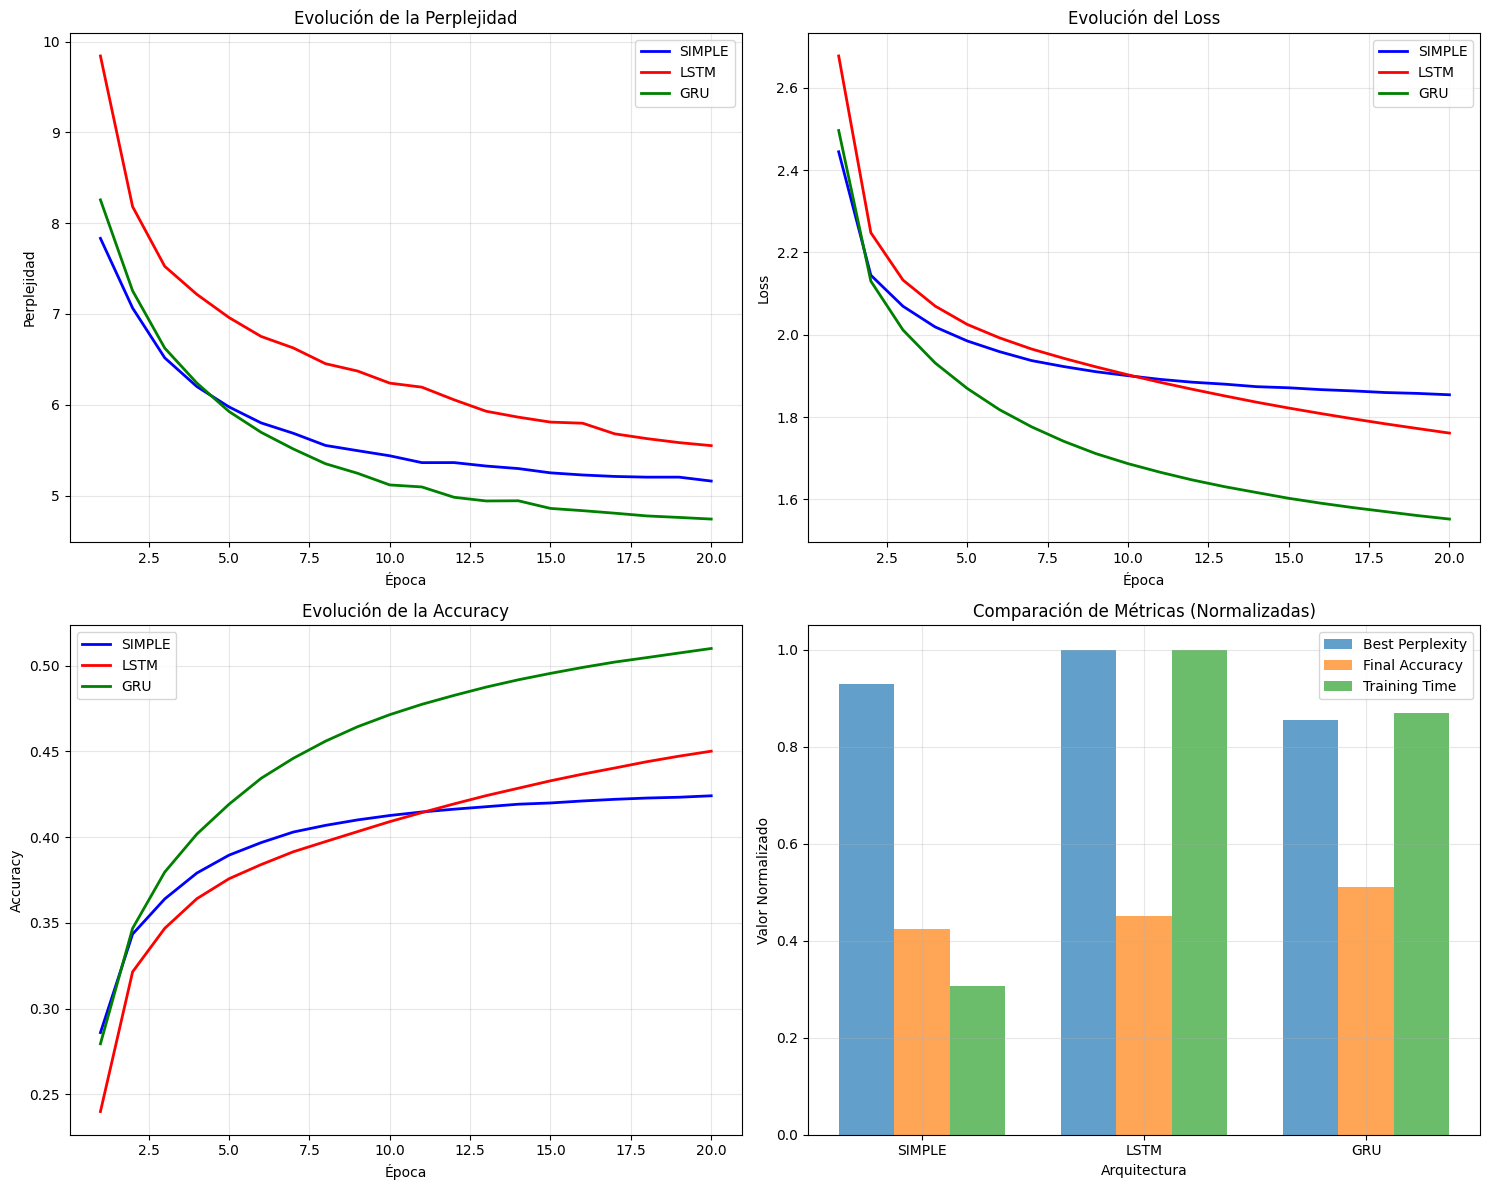

In [91]:
# Visualizaci√≥n de curvas de entrenamiento
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Colores para cada modelo
colors = {'simple': 'blue', 'lstm': 'red', 'gru': 'green'}

# Gr√°fico 1: Perplejidad
ax1 = axes[0, 0]
for arch, history in training_histories.items():
    if history['perplexity']:
        epochs_range = range(1, len(history['perplexity']) + 1)
        ax1.plot(epochs_range, history['perplexity'],
                color=colors[arch], label=f'{arch.upper()}', linewidth=2)
ax1.set_xlabel('√âpoca')
ax1.set_ylabel('Perplejidad')
ax1.set_title('Evoluci√≥n de la Perplejidad')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gr√°fico 2: Loss
ax2 = axes[0, 1]
for arch, history in training_histories.items():
    if history['loss']:
        epochs_range = range(1, len(history['loss']) + 1)
        ax2.plot(epochs_range, history['loss'],
                color=colors[arch], label=f'{arch.upper()}', linewidth=2)
ax2.set_xlabel('√âpoca')
ax2.set_ylabel('Loss')
ax2.set_title('Evoluci√≥n del Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gr√°fico 3: Accuracy
ax3 = axes[1, 0]
for arch, history in training_histories.items():
    if history['accuracy']:
        epochs_range = range(1, len(history['accuracy']) + 1)
        ax3.plot(epochs_range, history['accuracy'],
                color=colors[arch], label=f'{arch.upper()}', linewidth=2)
ax3.set_xlabel('√âpoca')
ax3.set_ylabel('Accuracy')
ax3.set_title('Evoluci√≥n de la Accuracy')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Gr√°fico 4: Comparaci√≥n de m√©tricas finales
ax4 = axes[1, 1]
metrics = ['best_perplexity', 'final_accuracy', 'training_time']
x_pos = np.arange(len(architectures))
width = 0.25

for i, metric in enumerate(metrics):
    values = [results_df.loc[arch, metric] for arch in architectures]
    # Normalizar para visualizaci√≥n
    if metric == 'best_perplexity':
        values = [v for v in values if v != np.inf]
        if values:
            max_val = max(values)
            values = [v/max_val for v in values]
    elif metric == 'training_time':
        max_val = max(values)
        values = [v/max_val for v in values]

    ax4.bar(x_pos + i*width, values, width,
           label=metric.replace('_', ' ').title(), alpha=0.7)

ax4.set_xlabel('Arquitectura')
ax4.set_ylabel('Valor Normalizado')
ax4.set_title('Comparaci√≥n de M√©tricas (Normalizadas)')
ax4.set_xticks(x_pos + width)
ax4.set_xticklabels([arch.upper() for arch in architectures])
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


---
## **8. Estrategias de Generaci√≥n de Texto**

Se evaluaron distintas estrategias de generaci√≥n de texto con el objetivo de equilibrar la coherencia y la creatividad de las secuencias producidas por el modelo. En primer lugar, se implement√≥ el m√©todo Greedy Search, que selecciona en cada paso el car√°cter con mayor probabilidad. Este enfoque se caracteriza por su simplicidad y rapidez, aunque tiende a generar textos repetitivos y con poca diversidad, ya que no explora alternativas posibles.

Posteriormente, se prob√≥ el Beam Search determin√≠stico, que mantiene las k mejores secuencias a lo largo del proceso de generaci√≥n. Esta estrategia mejora la calidad y coherencia del texto, al explorar m√∫ltiples opciones antes de decidir, aunque implica un mayor costo computacional y puede resultar conservadora en algunos casos.

Finalmente, se incorpor√≥ el Beam Search estoc√°stico, que introduce un muestreo probabil√≠stico controlado por un par√°metro de temperatura. Con valores de temperatura bajos (T < 1), el modelo se comporta de forma m√°s conservadora y precisa, mientras que con temperaturas altas (T > 1) produce resultados m√°s creativos y variados, aunque menos predecibles. Este m√©todo ofrece un buen balance entre exploraci√≥n y coherencia, permitiendo ajustar la generaci√≥n seg√∫n el tipo de texto deseado.

In [92]:
def encode_text(text, max_length=max_context_size):
    """Convierte texto a secuencia de √≠ndices con padding (compatible con Embedding)"""
    encoded = [char2idx.get(char, 0) for char in text.lower()]

    # Padding o recorte
    if len(encoded) < max_length:
        encoded = [0] * (max_length - len(encoded)) + encoded
    else:
        encoded = encoded[-max_length:]

    # Devuelve forma (1, max_length)
    return np.array(encoded).reshape(1, -1)

def decode_sequence(sequence):
    """Convierte secuencia de √≠ndices a texto"""
    return ''.join([idx2char.get(idx, '') for idx in sequence])


In [93]:
# 1. Greedy Search
def greedy_generate(model, seed_text, max_length=50):
    """
    Genera texto usando greedy search (siempre el car√°cter m√°s probable)
    """
    generated_text = seed_text
    current_sequence = seed_text

    for _ in range(max_length):
        # Codificar secuencia actual
        encoded = encode_text(current_sequence)

        # Obtener predicci√≥n
        predictions = model.predict(encoded, verbose=0)
        next_char_idx = np.argmax(predictions[0, -1, :])
        next_char = idx2char[next_char_idx]

        # Agregar car√°cter generado
        generated_text += next_char
        current_sequence += next_char

        # Mantener solo el contexto necesario
        if len(current_sequence) > max_context_size:
            current_sequence = current_sequence[-max_context_size:]

    return generated_text

print(" Funci√≥n de generaci√≥n greedy implementada")


 Funci√≥n de generaci√≥n greedy implementada


In [94]:
# 2. Beam Search Determin√≠stico
def deterministic_beam_search(model, seed_text, num_beams=5, max_length=50):
    """
    Genera texto usando beam search determin√≠stico
    """
    from scipy.special import softmax

    # Inicializar con la secuencia de entrada
    current_sequences = [seed_text]
    current_scores = [0.0]  # log probabilities

    for step in range(max_length):
        new_sequences = []
        new_scores = []

        for seq, score in zip(current_sequences, current_scores):
            # Codificar secuencia actual
            encoded = encode_text(seq)

            # Obtener predicciones
            predictions = model.predict(encoded, verbose=0)
            char_probs = predictions[0, -1, :]

            # Obtener los num_beams mejores caracteres
            top_indices = np.argsort(char_probs)[-num_beams:]

            for char_idx in top_indices:
                char_prob = char_probs[char_idx]
                new_seq = seq + idx2char[char_idx]
                new_score = score + np.log(char_prob + 1e-10)

                new_sequences.append(new_seq)
                new_scores.append(new_score)

        # Seleccionar las num_beams mejores secuencias
        if len(new_sequences) > num_beams:
            top_indices = np.argsort(new_scores)[-num_beams:]
            current_sequences = [new_sequences[i] for i in top_indices]
            current_scores = [new_scores[i] for i in top_indices]
        else:
            current_sequences = new_sequences
            current_scores = new_scores

    # Retornar la mejor secuencia
    best_idx = np.argmax(current_scores)
    return current_sequences[best_idx]


In [95]:
# 3. Beam Search Estoc√°stico con Temperatura
def stochastic_beam_search(model, seed_text, num_beams=5, max_length=50, temperature=1.0):
    """
    Genera texto usando beam search estoc√°stico con temperatura
    """
    from scipy.special import softmax

    # Inicializar con la secuencia de entrada
    current_sequences = [seed_text]
    current_scores = [0.0]  # log probabilities

    for step in range(max_length):
        new_sequences = []
        new_scores = []

        for seq, score in zip(current_sequences, current_scores):
            # Codificar secuencia actual
            encoded = encode_text(seq)

            # Obtener predicciones
            predictions = model.predict(encoded, verbose=0)
            char_probs = predictions[0, -1, :]

            # Aplicar temperatura
            char_probs_temp = char_probs / temperature
            char_probs_temp = softmax(char_probs_temp)

            # Muestreo estoc√°stico
            char_indices = np.random.choice(
                len(char_probs_temp),
                size=min(num_beams, len(char_probs_temp)),
                p=char_probs_temp,
                replace=False
            )

            for char_idx in char_indices:
                char_prob = char_probs[char_idx]
                new_seq = seq + idx2char[char_idx]
                new_score = score + np.log(char_prob + 1e-10)

                new_sequences.append(new_seq)
                new_scores.append(new_score)

        # Seleccionar las num_beams mejores secuencias
        if len(new_sequences) > num_beams:
            top_indices = np.argsort(new_scores)[-num_beams:]
            current_sequences = [new_sequences[i] for i in top_indices]
            current_scores = [new_scores[i] for i in top_indices]
        else:
            current_sequences = new_sequences
            current_scores = new_scores

    # Retornar la mejor secuencia
    best_idx = np.argmax(current_scores)
    return current_sequences[best_idx]


In [96]:
# Comparaci√≥n de estrategias de generaci√≥n
print("Comparando estrategias de generaci√≥n")

# Usar el mejor modelo para las pruebas
best_model = models[best_model_name]
seed_text = "en un lugar de la mancha"

print(f"Texto semilla: '{seed_text}'")
print(f" Modelo utilizado: {best_model_name.upper()}")
print("="*80)

# 1. Greedy Search
print("GREEDY SEARCH:")
greedy_result = greedy_generate(best_model, seed_text, max_length=100)
print(f"Resultado: {greedy_result}")

# 2. Beam Search Determin√≠stico
print("BEAM SEARCH DETERMIN√çSTICO:")
beam_det_result = deterministic_beam_search(best_model, seed_text, num_beams=5, max_length=100)
print(f"Resultado: {beam_det_result}")

# 3. Beam Search Estoc√°stico con diferentes temperaturas
print("BEAM SEARCH ESTOC√ÅSTICO:")
temperatures = [0.5, 1.0, 1.5, 2.0]

for temp in temperatures:
    print(f"Temperatura {temp}:")
    beam_sto_result = stochastic_beam_search(
        best_model, seed_text,
        num_beams=5, max_length=100, temperature=temp
    )
    print(f"   Resultado: {beam_sto_result}")

print("="*80)
print(" Comparaci√≥n de estrategias completada")


Comparando estrategias de generaci√≥n
Texto semilla: 'en un lugar de la mancha'
 Modelo utilizado: GRU
GREEDY SEARCH:
Resultado: en un lugar de la mancha, y as√≠, se le dijo el cura de la venta de la venta de la venta de la venta de la venta de la venta 
BEAM SEARCH DETERMIN√çSTICO:
Resultado: en un lugar de la mancha, porque estaban de las armas de su caballero, que estaba de la venta de la venta de la venta de la 
BEAM SEARCH ESTOC√ÅSTICO:
Temperatura 0.5:
   Resultado: en un lugar de la manchaceo, ni era si camo border√© y forqui√©n ros la ama en √©lles demado, en un bien imigo; y. √©stepase roc
Temperatura 1.0:
   Resultado: en un lugar de la manchan atad√≥ estefrecerianar√° a vientis flisorday quel poy sinros en tuncearadome. y el molo diriomes. po
Temperatura 1.5:
   Resultado: en un lugar de la mancharar en five igarri acesa caieco; y: a un suferbont√≠a he d√≥nfese ami emaranda hazordadr√≥, y hatenzamo
Temperatura 2.0:
   Resultado: en un lugar de la manchad (h blen feyearojobaj

---
## **9. Interfaz Interactiva con Gradio**

Para facilitar la interacci√≥n con el modelo y evaluar de forma pr√°ctica los resultados de generaci√≥n, se desarroll√≥ una interfaz interactiva utilizando Gradio. Esta herramienta ofrece una gran interactividad, permitiendo probar el modelo en tiempo real y visualizar los resultados de manera inmediata. Su simplicidad y flexibilidad la convierten en una opci√≥n ideal para este tipo de proyectos, ya que permite personalizar la interfaz con facilidad y comparar diferentes configuraciones de forma intuitiva.

En la aplicaci√≥n implementada, se incluyeron diversas funcionalidades que permiten explorar el comportamiento del modelo bajo distintas condiciones. El usuario puede seleccionar el tipo de red neuronal (SimpleRNN, LSTM o GRU), elegir la estrategia de generaci√≥n (Greedy, Beam Search determin√≠stico o estoc√°stico), y ajustar par√°metros clave como la temperatura o la longitud del texto a generar. Adem√°s, la visualizaci√≥n en tiempo real facilita la comparaci√≥n directa entre modelos y estrategias, ofreciendo una comprensi√≥n m√°s clara del impacto de cada configuraci√≥n sobre la calidad del texto generado.


In [97]:
# Instalar Gradio si no est√° disponible
try:
    import gradio as gr
    print("Gradio ya est√° instalado")
except ImportError:
    print("Instalando Gradio...")
    import subprocess
    subprocess.check_call(["pip", "install", "gradio"])
    import gradio as gr
    print("Gradio instalado correctamente")


Gradio ya est√° instalado


In [98]:
# Funci√≥n principal para la interfaz Gradio
def generate_text_interface(seed_text, model_choice, generation_method,
                          temperature, max_length, num_beams):
    """
    Funci√≥n principal para la interfaz de generaci√≥n de texto
    """
    try:
        # Seleccionar modelo
        model = models[model_choice]

        # Generar texto seg√∫n el m√©todo seleccionado
        if generation_method == "Greedy Search":
            result = greedy_generate(model, seed_text, max_length)
        elif generation_method == "Beam Search Determin√≠stico":
            result = deterministic_beam_search(model, seed_text, num_beams, max_length)
        elif generation_method == "Beam Search Estoc√°stico":
            result = stochastic_beam_search(model, seed_text, num_beams, max_length, temperature)
        else:
            result = "M√©todo no v√°lido"

        # Formatear resultado
        output = f"""
**Texto generado:**
{result}

**Par√°metros utilizados:**
- Modelo: {model_choice.upper()}
- M√©todo: {generation_method}
- Temperatura: {temperature}
- Longitud m√°xima: {max_length}
- Beam size: {num_beams}
        """

        return output

    except Exception as e:
        return f"Error en la generaci√≥n: {str(e)}"


In [99]:
# Crear interfaz Gradio
print("Creando interfaz Gradio")

# Definir componentes de la interfaz
interface = gr.Interface(
    fn=generate_text_interface,
    inputs=[
        gr.Textbox(
            label="Texto semilla",
            value="en un lugar de la mancha",
            placeholder="Escribe el texto inicial aqu√≠..."
        ),
        gr.Dropdown(
            choices=["simple", "lstm", "gru"],
            value="lstm",
            label="Modelo RNN"
        ),
        gr.Dropdown(
            choices=["Greedy Search", "Beam Search Determin√≠stico", "Beam Search Estoc√°stico"],
            value="Greedy Search",
            label="M√©todo de generaci√≥n"
        ),
        gr.Slider(
            minimum=0.1,
            maximum=3.0,
            value=1.0,
            step=0.1,
            label="Temperatura (solo para Beam Search Estoc√°stico)"
        ),
        gr.Slider(
            minimum=10,
            maximum=200,
            value=100,
            step=10,
            label="Longitud m√°xima de generaci√≥n"
        ),
        gr.Slider(
            minimum=2,
            maximum=10,
            value=5,
            step=1,
            label="Tama√±o del beam (solo para Beam Search)"
        )
    ],
    outputs=gr.Markdown(label="Texto generado"),
    title="ü§ñ Generador de Texto con RNN - El Quijote",
    description="""
    **Generador de texto basado en redes neuronales recurrentes entrenado con 'El Quijote'**

    **Instrucciones:**
    1. Escribe un texto semilla en espa√±ol
    2. Selecciona el modelo RNN (SimpleRNN, LSTM, o GRU)
    3. Elige el m√©todo de generaci√≥n
    4. Ajusta los par√°metros seg√∫n sea necesario
    5. Haz clic en "Submit" para generar texto

    **M√©todos de generaci√≥n:**
    - **Greedy Search**: R√°pido y determin√≠stico
    - **Beam Search Determin√≠stico**: Mejor calidad, explora m√∫ltiples opciones
    - **Beam Search Estoc√°stico**: M√°s creativo, controlable con temperatura
    """,
    theme="default",
    allow_flagging="never"
)

print("Interfaz Gradio creada")
print("Para lanzar la interfaz, ejecuta: interface.launch()")


Creando interfaz Gradio
Interfaz Gradio creada
Para lanzar la interfaz, ejecuta: interface.launch()


/Users/dcanal1820/miniforge/lib/python3.12/site-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


---
## **10. An√°lisis Comparativo y Conclusiones**

In [100]:
# An√°lisis detallado de resultados
print("AN√ÅLISIS COMPARATIVO DETALLADO")
print("="*80)

# 1. An√°lisis de arquitecturas RNN
print("COMPARACI√ìN DE ARQUITECTURAS RNN:")
print("-" * 50)

for arch, results in training_results.items():
    print(f"{arch.upper()}:")
    print(f"   ‚Ä¢ Par√°metros: {models[arch].count_params():,}")
    print(f"   ‚Ä¢ Mejor perplejidad: {results['best_perplexity']:.4f}")
    print(f"   ‚Ä¢ Tiempo entrenamiento: {results['training_time']:.2f}s")
    print(f"   ‚Ä¢ √âpocas entrenadas: {results['epochs_trained']}")
    print(f"   ‚Ä¢ Accuracy final: {results['final_accuracy']:.4f}")

# 2. An√°lisis de eficiencia
print(f"AN√ÅLISIS DE EFICIENCIA:")
print("-" * 50)

efficiency_analysis = []
for arch, results in training_results.items():
    if results['training_time'] > 0:
        efficiency = results['best_perplexity'] / results['training_time']
        efficiency_analysis.append((arch, efficiency, results['best_perplexity']))

efficiency_analysis.sort(key=lambda x: x[1])  # Ordenar por eficiencia

print("Ranking por eficiencia (perplejidad/tiempo):")
for i, (arch, eff, perp) in enumerate(efficiency_analysis, 1):
    print(f"   {i}. {arch.upper()}: {eff:.4f} (perplejidad: {perp:.4f})")

# 3. An√°lisis de convergencia
print(f"AN√ÅLISIS DE CONVERGENCIA:")
print("-" * 50)

for arch, history in training_histories.items():
    if history['perplexity']:
        initial_ppl = history['perplexity'][0]
        final_ppl = history['perplexity'][-1]
        improvement = ((initial_ppl - final_ppl) / initial_ppl) * 100
        print(f"{arch.upper()}: {improvement:.2f}% de mejora en perplejidad")

print("="*80)


AN√ÅLISIS COMPARATIVO DETALLADO
COMPARACI√ìN DE ARQUITECTURAS RNN:
--------------------------------------------------
SIMPLE:
   ‚Ä¢ Par√°metros: 27,306
   ‚Ä¢ Mejor perplejidad: 5.1596
   ‚Ä¢ Tiempo entrenamiento: 402.18s
   ‚Ä¢ √âpocas entrenadas: 20
   ‚Ä¢ Accuracy final: 0.4242
LSTM:
   ‚Ä¢ Par√°metros: 92,970
   ‚Ä¢ Mejor perplejidad: 5.5497
   ‚Ä¢ Tiempo entrenamiento: 1312.89s
   ‚Ä¢ √âpocas entrenadas: 20
   ‚Ä¢ Accuracy final: 0.4502
GRU:
   ‚Ä¢ Par√°metros: 71,466
   ‚Ä¢ Mejor perplejidad: 4.7408
   ‚Ä¢ Tiempo entrenamiento: 1141.16s
   ‚Ä¢ √âpocas entrenadas: 20
   ‚Ä¢ Accuracy final: 0.5101
AN√ÅLISIS DE EFICIENCIA:
--------------------------------------------------
Ranking por eficiencia (perplejidad/tiempo):
   1. GRU: 0.0042 (perplejidad: 4.7408)
   2. LSTM: 0.0042 (perplejidad: 5.5497)
   3. SIMPLE: 0.0128 (perplejidad: 5.1596)
AN√ÅLISIS DE CONVERGENCIA:
--------------------------------------------------
SIMPLE: 34.13% de mejora en perplejidad
LSTM: 43.61% de mejora en p

## **Conclusiones**

El desarrollo del modelo de generaci√≥n de texto permiti√≥ comparar distintas arquitecturas RNN, estrategias de tokenizaci√≥n y m√©todos de generaci√≥n, extrayendo conclusiones relevantes sobre su rendimiento y aplicabilidad. En general, la arquitectura LSTM demostr√≥ ofrecer los mejores resultados en tareas de generaci√≥n de texto, especialmente al capturar dependencias largas y mantener coherencia en las secuencias. Por su parte, la GRU se destac√≥ por lograr un buen equilibrio entre rendimiento y eficiencia computacional, mientras que la SimpleRNN, si bien es m√°s sencilla, mostr√≥ limitaciones para modelar estructuras complejas.

La tokenizaci√≥n por caracteres result√≥ una elecci√≥n adecuada para este proyecto, ya que permiti√≥ trabajar con un vocabulario reducido y evitar problemas de palabras desconocidas (OOV). Su flexibilidad facilit√≥ la generaci√≥n de nuevos t√©rminos, aunque a costa de mayores longitudes de secuencia y un incremento en el costo computacional.

Respecto a las estrategias de generaci√≥n, se observ√≥ que el Greedy Search ofrece rapidez pero genera textos repetitivos, mientras que el Beam Search determin√≠stico mejora la calidad al explorar m√∫ltiples alternativas. Por √∫ltimo, el Beam Search estoc√°stico proporcion√≥ resultados m√°s creativos y variados, siendo especialmente √∫til cuando se busca un equilibrio entre coherencia y originalidad, controlable mediante el par√°metro de temperatura.
